## 20200923-181126-network-RMSprop

In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.append('../')
import utils.data_preprocess as preprocess
from utils.model_metrics import ModelMetric
from utils.mode_figure import ModelFigre
import datetime
from utils.model_callback import step_decay, exp_decay, MyStopTrainCallBack

In [2]:
modelmetric = ModelMetric()

In [3]:
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, GaussianNoise, Flatten, Dense, Input, Activation
from tensorflow.keras import Model
dos_input = Input(shape=(1, 77))
forward_layer_one = LSTM(64, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=4) , recurrent_constraint=tf.keras.constraints.MaxNorm(max_value=4), return_sequences=True)
backward_layer_one = LSTM(64, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=4) , recurrent_constraint=tf.keras.constraints.MaxNorm(max_value=4), return_sequences=True , go_backwards=True)
bi_one = Bidirectional(forward_layer_one, backward_layer=backward_layer_one, name='bi_one')(dos_input)

noise_one = GaussianNoise(0.5)(bi_one)

bn_one = BatchNormalization()(noise_one)

forward_layer_two = LSTM(32, return_sequences=True)
backward_layer_two = LSTM(32, return_sequences=True, go_backwards=True)
bi_two = Bidirectional(forward_layer_two, backward_layer=backward_layer_two, name='bi_two')(bn_one)

bn_two = BatchNormalization()(bi_two)

forward_layer_three = LSTM(16,)
backward_layer_three = LSTM(16, go_backwards=True)
bi_three = Bidirectional(forward_layer_three, backward_layer=backward_layer_three, name='bi_three')(bn_two)

bn_three = BatchNormalization()(bi_three)

flatten_one = Flatten()(bn_three)

dense_four = Dense(16, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=4), name='dense_three')(flatten_one)
noise_two = GaussianNoise(0.5)(dense_four)
avtivation_four = Activation(tf.nn.relu6, name='dense_four_activation')(noise_two)

bn_four = BatchNormalization()(avtivation_four)

dense = Dense(2, name='classification')(bn_four)
output_res = Activation(tf.nn.softmax, name='classifi')(dense)

model = Model(inputs=dos_input, outputs=output_res)

# algorithm = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, clipvalue=0.3, momentum=0.9, epsilon=1e-07, decay= 1e-06, centered=False, name='RMSprop')
algorithm = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.99, clipvalue=0.2, nesterov=True, name='SGD')

model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=modelmetric.metric('binary_crossentropy')) # categorical_crossentropycategorical_crossentropy

In [4]:
from tensorflow.keras import callbacks
dir_name = datetime.datetime.now().strftime("Best-%Y%m%d-%H%M%S-SGD")

logdir = os.path.join("../tensorboard", dir_name)
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)
lrate = callbacks.LearningRateScheduler(step_decay)
csv_log = tf.keras.callbacks.CSVLogger('../model_record/'+dir_name+"/log", separator=',', append=False)
if not os.path.isdir('../model_record/'+dir_name):
    os.mkdir('../model_record/'+dir_name)
    os.mkdir('../model_record/'+dir_name+'/model')
# stop_train = MyStopTrainCallBack()
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [5]:
pre = preprocess.preprocess("D:/DataSet/CICIDS2017/CSV/Wednesday-workingHours.pcap_ISCX.csv", labelColumnName='Label', depth=2)
X_train, X_test, y_train, y_test = pre.preprocessing()
X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = tf.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [6]:
import numpy as np
model_ = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_split=0.3, callbacks=[tensorboard_callback, csv_log, lrate], verbose=1) # lrate

89 - val_binary_accuracy: 0.9853 - val_binary_crossentropy: 0.0405 - lr: 0.0016
Epoch 64/100
662/662 [==============================] - 16s 25ms/step - loss: 0.0422 - tp: 333518.0000 - fp: 5270.0000 - tn: 333518.0000 - fn: 5270.0000 - acc: 0.0062 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - binary_accuracy: 0.9844 - binary_crossentropy: 0.0422 - val_loss: 0.0406 - val_tp: 143031.0000 - val_fp: 2165.0000 - val_tn: 143031.0000 - val_fn: 2165.0000 - val_acc: 0.0048 - val_precision: 0.9851 - val_recall: 0.9851 - val_auc: 0.9989 - val_binary_accuracy: 0.9851 - val_binary_crossentropy: 0.0406 - lr: 0.0016
Epoch 65/100
662/662 [==============================] - 18s 27ms/step - loss: 0.0425 - tp: 333484.0000 - fp: 5304.0000 - tn: 333484.0000 - fn: 5304.0000 - acc: 0.0063 - precision: 0.9843 - recall: 0.9843 - auc: 0.9988 - binary_accuracy: 0.9843 - binary_crossentropy: 0.0425 - val_loss: 0.0405 - val_tp: 143065.0000 - val_fp: 2131.0000 - val_tn: 143065.0000 - val_fn: 2131.0000 - val_ac

In [7]:
results  = model.evaluate(X_test, y_test, verbose=1)
modelmetric.getTrainMetricValue(model, results)

6482/6482 [==============================] - 66s 10ms/step - loss: 0.0402 - tp: 204424.0000 - fp: 2998.0000 - tn: 204424.0000 - fn: 2998.0000 - acc: 0.0110 - precision: 0.9855 - recall: 0.9855 - auc: 0.9989 - binary_accuracy: 0.9855 - binary_crossentropy: 0.0402
loss :  0.04015178233385086
tp :  204424.0
fp :  2998.0
tn :  204424.0
fn :  2998.0
acc :  0.011001725681126118
precision :  0.985546350479126
recall :  0.985546350479126
auc :  0.9989038109779358
binary_accuracy :  0.985546350479126
binary_crossentropy :  0.04015178233385086


In [8]:
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis=1)
y_label = np.argmax(y_test, axis=1)
modelmetric.confusion_matrix(y_label, y_class)
modelmetric.eva_metric(y_label, y_class)

TrueNegatives result:  129157.0
TruePositives result:  75267.0
FalseNegatives result:  134.0
FalsePositives result:  2864.0
Recall result:  0.9982228
Precision result:  0.9633436


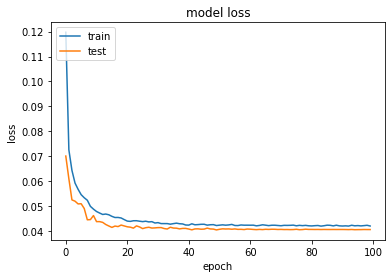

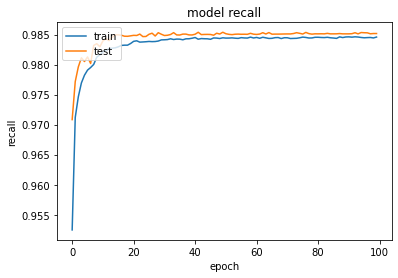

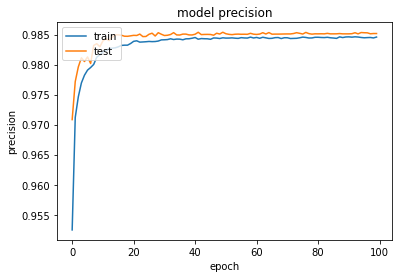

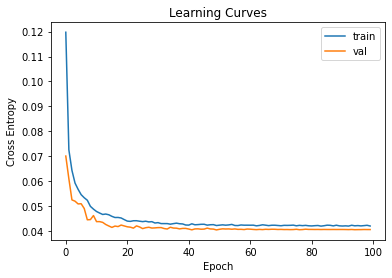

In [9]:
mf = ModelFigre("../model_record", dir_name, model_)
mf.loss_graph()
mf.recall_graph()
mf.precision_graph()
mf.cross_entropy_graph()
# fig.save_model(net,dir_name)

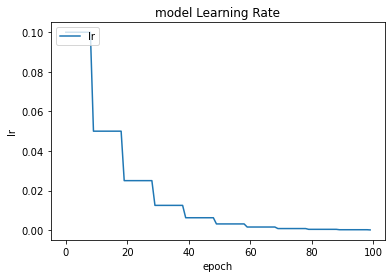

In [10]:
mf.lr_graph()

In [12]:
model.save('../model_record/'+dir_name+'/model/model.h5')